<a href="https://colab.research.google.com/github/roque-alfaro/taller-eiv-2026/blob/main/2_Ejercicio_Normalizaci%C3%B3n_(Python).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ejercicio: Normalización de datos

En este ejercicio vamos normalizar los datos de la demanda y la oferta de consultas de especialidad médica en el Servicio de Salud Metropolitano Sur Oriente en 2021. Vamos a  organizar los datos de manera eficiente para minimizar la redundancia y mejorar la integridad de los datos. Para ello es necesario:

1. Identificar las entidades y relaciones en un diagrama E-R
1. Normalizar datos de Demanda (interconsultas)
1. Normalizar datos de Especialidades
3. Normalizar datos de Oferta (producción)

## Modelo Entidad-Relación 🎨

Primero es necesario tener un esquema de qué describen los datos e identificar las tablas necesarias. En este ejercicio podemos identificar as entidades:

- Centro de salud
- Demanda
- Producción histórica
- Programación
- Especialidad


# Configurar área de trabajo

In [48]:
# Importar librerías
import pandas as pd
import os

# Definir carpetas de trabajo
datos_originales = 'https://github.com/rlagosb/taller_eiv/raw/refs/heads/main/data/'
datos_crudos = 'https://github.com/rlagosb/taller_eiv/raw/refs/heads/main/datos_crudos/'
datos_normalizados = '/content/datos_normalizados/'

# Crear carpetas
if not os.path.exists(datos_crudos): os.makedirs(datos_crudos)
if not os.path.exists(datos_normalizados): os.makedirs(datos_normalizados)

In [49]:
# cargar datos
sic = pd.read_parquet(datos_crudos + 'sic_2021_SSMSO.parquet')
programacion = pd.read_parquet(datos_crudos + 'programacion_2021_SSMSO.parquet')
produccion = pd.read_parquet(datos_crudos + 'rem_A07_2021_SSMSO.parquet')

# 1- Normalizar demanda (solicitudes de interconsulta)

In [50]:
# Examinemos la fuente de los datos de demanda
# ¿Cuáles campos son redundantes o innecesarios para nuestro análisis?
print(sic.info())
sic.sample(5)

<class 'pandas.core.frame.DataFrame'>
Index: 150632 entries, 0 to 149475
Data columns (total 8 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   FECHA_NAC   150632 non-null  datetime64[us]
 1   SEXO        150632 non-null  int64         
 2   TIPO_PREST  150632 non-null  int64         
 3   PRESTA_MIN  150632 non-null  object        
 4   PRESTA_EST  150632 non-null  object        
 5   F_ENTRADA   150632 non-null  datetime64[ns]
 6   ESTAB_ORIG  150632 non-null  int64         
 7   ESTAB_DEST  150632 non-null  int64         
dtypes: datetime64[ns](1), datetime64[us](1), int64(4), object(2)
memory usage: 10.3+ MB
None


,FECHA_NAC,SEXO,TIPO_PREST,PRESTA_MIN,PRESTA_EST,F_ENTRADA,ESTAB_ORIG,ESTAB_DEST
126591,1970-01-01 00:00:00.013915,2,1,07-044,Oftalmologia,2021-09-06,114303,114105
71832,1970-01-01 00:00:00.044232,2,1,07-042,NEUROLOGIA INFANTIL,2021-09-22,114101,114101
121656,1970-01-01 00:00:00.016125,1,1,07-054,Urologia,2021-09-29,114105,114105
20978,1970-01-01 00:00:00.016068,2,1,07-054,Urologia,2021-05-24,114105,114105
143683,1970-01-01 00:00:00.015568,1,1,07-054,Urologia,2021-11-09,114103,114103


In [51]:
demanda = sic[['PRESTA_MIN','F_ENTRADA','ESTAB_DEST']].copy()

demanda

,PRESTA_MIN,F_ENTRADA,ESTAB_DEST
0,07-064,2021-01-04,114101
1,07-056,2021-01-04,114101
2,07-058,2021-01-04,114101
3,09-008,2021-01-04,114101
4,09-008,2021-01-04,114105
...,...,...,...
149471,09-001,2021-09-07,114101
149472,07-030,2021-12-21,114101
149473,07-030,2021-10-29,114101
149474,07-030,2021-11-25,114101


In [52]:
# Usaremos sólo el mes y año y botaremos la fecha exacta de la interconsulta
demanda.loc[:,'Año']=demanda['F_ENTRADA'].dt.year
demanda.loc[:,'Mes']=demanda['F_ENTRADA'].dt.month
del demanda['F_ENTRADA']
demanda

,PRESTA_MIN,ESTAB_DEST,Año,Mes
0,07-064,114101,2021,1
1,07-056,114101,2021,1
2,07-058,114101,2021,1
3,09-008,114101,2021,1
4,09-008,114105,2021,1
...,...,...,...,...
149471,09-001,114101,2021,9
149472,07-030,114101,2021,12
149473,07-030,114101,2021,10
149474,07-030,114101,2021,11


In [53]:
# Con los datos normalizados podemos agregar los registros y usar un contador
demanda = demanda.value_counts().reset_index()

demanda.rename(columns={'count':'Interconsultas',
                        'PRESTA_MIN':'Especialidad',
                        'ESTAB_DEST':'Centro_destino',
                        },
               inplace=True)

# Revisamos el dataframe resultante
print(demanda.info())
print(demanda.describe())
demanda.sample(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2149 entries, 0 to 2148
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Especialidad    2149 non-null   object
 1   Centro_destino  2149 non-null   int64 
 2   Año             2149 non-null   int32 
 3   Mes             2149 non-null   int32 
 4   Interconsultas  2149 non-null   int64 
dtypes: int32(2), int64(2), object(1)
memory usage: 67.3+ KB
None
       Centro_destino     Año          Mes  Interconsultas
count     2149.000000  2149.0  2149.000000     2149.000000
mean    126013.181945  2021.0     6.514193       70.093997
std      29748.516674     0.0     3.466709       89.067837
min     114101.000000  2021.0     1.000000        1.000000
25%     114101.000000  2021.0     3.000000       17.000000
50%     114103.000000  2021.0     7.000000       42.000000
75%     114105.000000  2021.0    10.000000       90.000000
max     200282.000000  2021.0    12.000000      

,Especialidad,Centro_destino,Año,Mes,Interconsultas
927,07-047,114105,2021,1,50
592,07-047,114103,2021,6,81
114,07-054,114101,2021,3,226
792,07-048,114103,2021,3,60
1938,09-008,114105,2021,2,6


In [54]:
# Exportar a la carpeta de Datos Normalizados
demanda.to_excel(datos_normalizados + 'Demanda.xlsx',index=False)

## 🏁 Discusión

1. ¿Qué datos se perdieron al normalizar y agrupar los datos de demada?
2. ¿En qué incide?
3. Si más adelante necesitara incluir alguno de los campos excluidos (ej. sexo)  ¿qué tendría que hacer?

# 2- Normalizar especialidades

Debemos elegir un estándar para identificar las especialidades de las consultas médicas en nuestro análisis. Note que las solicitudes de interconsulta (sic) y la producción tienen distinta codificación.

In [55]:
print(sic.PRESTA_MIN.value_counts().head(3),end='\n\n')
print(produccion.CodigoPrestacion.value_counts().head(3))

PRESTA_MIN
07-053    12554
07-044     9697
07-004     9002
Name: count, dtype: int64

CodigoPrestacion
7021700    48
7023702    48
7024000    48
Name: count, dtype: int64


Debemos crear una tabla maestra **especialidades**.  Utilizaremos la [Norma Técnica 820 de Estándares de Información de Salud](https://repositoriodeis.minsal.cl/ContenidoSitioWeb2020/EstandaresNormativa/Decreto-Exento-643-Sustituye-Norma-T%C3%A9cnica-sobre-Est%C3%A1ndares-de-Informaci%C3%B3n-de-Salud-Actualizada-a-Dic-2016.pdf) en que están codificadas las especialidad de las interconsultas.

In [56]:
# Obtenemos el diccionario de códigos de especialidades médicas de las interconsultas
especialidades = pd.read_excel(datos_originales + 'SS_MSOr_Respuesta%20Solicitud%20Folio%20AO012T0001655%20(CNE%202021).xlsx',
                               sheet_name='diccionario',
                               header=None,
                               usecols="A:B",
                               names=['Codigo','Nombre'],
                               skiprows=47,
                               nrows=68)
especialidades

,Codigo,Nombre
0,07-001,ANATOMÍA PATOLÓGICA
1,07-002,ANESTESIOLOGÍA
2,07-003,CARDIOLOGÍA
3,07-004,CIRUGÍA GENERAL
4,07-005,"CIRUGÍA DE CABEZA, CUELLO Y MAXILOFACIAL"
...,...,...
63,07-064,NUTRIÓLOGO PEDIÁTRICO
64,07-065,REUMATOLOGÍA PEDIÁTRICA
65,07-066,OBSTETRICIA
66,07-067,TRAUMATOLOGÍA Y ORTOPEDIA PEDIÁTRICA


## 🏁 Discusión
1. ¿Cuántas especialidades existen en nuestra base de datos?
2. ¿Cuál es el identificador (llave primaria) de una especialidad?
1. ¿Qué atributos tiene cada Especialidad?

## Agregar Especialidad_programacion
Ahora agregaremos la codificación de la Programación (que es la misma que la Producción) a la tabla Especialidades

In [57]:
# Creamos una tabla auxiliar con las especialidades de la programación
especialidades_prog = pd.read_excel(datos_originales + 'programacion/114101_Planilla_programacion_PM_y_PNM_2021_FN_v12.xlsx',
                                   sheet_name='Diccionarios',
                                   header=None,
                                   usecols='B:C',
                                   names=['Codigo_prog','Nombre_prog'],
                                   skiprows=2,
                                   nrows=64)
especialidades_prog

,Codigo_prog,Nombre_prog
0,7030997,ANATOMÍA PATOLÓGICA
1,7023100,ANESTESIOLOGÍA
2,7020500,CARDIOLOGÍA ADULTO
3,7024219,CARDIOLOGÍA PEDIÁTRICA
4,7021701,CIRUGÍA CARDIOVASCULAR
...,...,...
59,7021101,REUMATOLOGÍA PEDIÁTRICA
60,7023702,TRAUMATOLOGÍA Y ORTOPEDIA ADULTO
61,7023701,TRAUMATOLOGÍA Y ORTOPEDIA PEDIÁTRICA
62,7024000,UROLOGÍA ADULTO


Para comparar las especialidades de dos fuentes de información necesitamos hacer un [JOIN](https://agscl.github.io/Est-Aplicada-UDP-2024/Clase4.html#11) (cruce) de tablas.

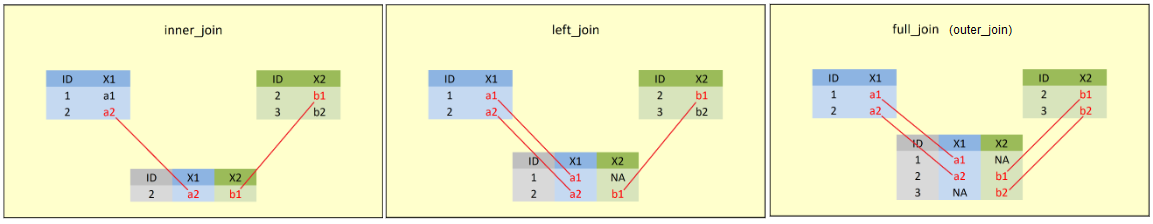


In [58]:
# cruzamos ambos diccionarios y revisamos las especialidades sin match
# outer join permite hacer el cruce de dos dataframes conservando los registros incompatibles de ambos
cruce = especialidades.merge(especialidades_prog,
                                       left_on='Nombre',
                                       right_on='Nombre_prog',
                                       how='outer')

cruce

,Codigo,Nombre,Codigo_prog,Nombre_prog
0,07-001,ANATOMÍA PATOLÓGICA,7030997.0,ANATOMÍA PATOLÓGICA
1,07-002,ANESTESIOLOGÍA,7023100.0,ANESTESIOLOGÍA
2,07-003,CARDIOLOGÍA,NaN,NaN
3,NaN,NaN,7020500.0,CARDIOLOGÍA ADULTO
4,07-055,CARDIOLOGÍA PEDIÁTRICA,7024219.0,CARDIOLOGÍA PEDIÁTRICA
...,...,...,...,...
88,NaN,NaN,7023702.0,TRAUMATOLOGÍA Y ORTOPEDIA ADULTO
89,07-067,TRAUMATOLOGÍA Y ORTOPEDIA PEDIÁTRICA,7023701.0,TRAUMATOLOGÍA Y ORTOPEDIA PEDIÁTRICA
90,07-054,UROLOGÍA,NaN,NaN
91,NaN,NaN,7024000.0,UROLOGÍA ADULTO


In [59]:
# obtenemos las especialidades de programación que no coinciden
# observe que obtenemos los datos en formato array en vez de un dataframe
cruce['Nombre_prog'][cruce['Nombre'].isna()].array

<NumpyExtensionArray>
[                                                'CARDIOLOGÍA ADULTO',
                                           'CIRUGÍA DIGESTIVA (ALTA)',
                                             'CIRUGÍA GENERAL ADULTO',
                               'CIRUGÍA PLÁSTICA Y REPARADORA ADULTO',
                           'CIRUGÍA PLÁSTICA Y REPARADORA PEDIÁTRICA',
                                                      'CIRUGÍA TÓRAX',
                           'COLOPROCTOLOGÍA (CIRUGIA DIGESTIVA BAJA)',
                 'ENFERMEDAD RESPIRATORIA DE ADULTO (BRONCOPULMONAR)',
       'ENFERMEDAD RESPIRATORIA PEDIÁTRICA (BRONCOPULMONAR INFANTIL)',
                                                 'GINECOLOGÍA ADULTO',
                                          'HEMATO-ONCOLOGÍA INFANTIL',
                                                 'HEMATOLOGÍA ADULTO',
                                                'INFECTOLOGÍA ADULTO',
                                            'INFECTOLOG

In [60]:
# obtenemos las especialidades 820 sin match
cruce['Nombre'][cruce['Nombre_prog'].isna()].array

<NumpyExtensionArray>
[                                                       'CARDIOLOGÍA',
                                                   'CIRUGÍA DE TÓRAX',
                                                  'CIRUGÍA DIGESTIVA',
                                                    'CIRUGÍA GENERAL',
                           'CIRUGÍA PLASTICA Y REPARADORA PEDIÁTRICA',
                                      'CIRUGÍA PLÁSTICA Y REPARADORA',
                                                    'COLOPROCTOLOGÍA',
             'ENFERMEDADES RESPIRATORIAS DEL ADULTO (BRONCOPULMONAR)',
 'ENFERMEDADES RESPIRATORIAS PEDIÁTRICAS (BRONCOPULMONAR PEDIATRICO)',
                                                        'GINECOLOGÍA',
                                        'HEMATO-ONCOLOGÍA PEDIÁTRICA',
                                                        'HEMATOLOGÍA',
                                                       'INFECTOLOGÍA',
                                            'INFECTOLOG

In [61]:
# homologamos a la norma 820 las especialidades de programación sin match
# por ej., el original CARDIOLOGÍA ADULTO lo adaptamos a CARDIOLOGÍA
match_especialidad={'CARDIOLOGÍA ADULTO':'CARDIOLOGÍA',
     'CIRUGÍA DIGESTIVA (ALTA)':'CIRUGÍA DIGESTIVA',
     'CIRUGÍA GENERAL ADULTO':'CIRUGÍA GENERAL',
     'CIRUGÍA PLÁSTICA Y REPARADORA ADULTO':'CIRUGÍA PLÁSTICA Y REPARADORA',
     'CIRUGÍA PLÁSTICA Y REPARADORA PEDIÁTRICA':'CIRUGÍA PLASTICA Y REPARADORA PEDIÁTRICA',
     'CIRUGÍA TÓRAX':'CIRUGÍA DE TÓRAX',
     'COLOPROCTOLOGÍA (CIRUGIA DIGESTIVA BAJA)':'COLOPROCTOLOGÍA',
     'ENFERMEDAD RESPIRATORIA DE ADULTO (BRONCOPULMONAR)':'ENFERMEDADES RESPIRATORIAS DEL ADULTO (BRONCOPULMONAR)',
     'ENFERMEDAD RESPIRATORIA PEDIÁTRICA (BRONCOPULMONAR INFANTIL)':'ENFERMEDADES RESPIRATORIAS PEDIÁTRICAS (BRONCOPULMONAR PEDIATRICO)',
     'GINECOLOGÍA ADULTO':'GINECOLOGÍA',
     'HEMATO-ONCOLOGÍA INFANTIL':'HEMATO-ONCOLOGÍA PEDIÁTRICA',
     'HEMATOLOGÍA ADULTO':'HEMATOLOGÍA',
     'INFECTOLOGÍA ADULTO':'INFECTOLOGÍA',
     'INFECTOLOGÍA PEDIÁTRICA':'INFECTOLOGÍA PEDIATRICA',
     'LABORATORIO CLINICO':'LABORATORIO CLÍNICO',
     'MEDICINA FÍSICA Y REHABILITACIÓN ADULTO (FISIATRÍA ADULTO)':'MEDICINA FÍSICA Y REHABILITACIÓN (FISIATRIA ADULTO)',
     'MEDICINA FÍSICA Y REHABILITACIÓN PEDIÁTRICA (FISIATRÍA PEDIÁTRICA)':'MEDICINA FISICA Y REHABILITACIÓN PEDIÁTRICA (FISIATRIA PEDIATRICA)',
     'MEDICINA INTENSIVA':'MEDICINA INTENSIVA ADULTO',
     'MEDICINA NUCLEAR (EXCLUYE INFORMES)':'MEDICINA NUCLEAR',
     'NEFROLOGÍA PEDIÁTRICA':'NEFROLOGÍA PEDIÁTRICO',
     'NUTRIÓLOGO ADULTO':'NUTRIÓLOGO',
     'REUMATOLOGÍA ADULTO':'REUMATOLOGÍA',
     'TRAUMATOLOGÍA Y ORTOPEDIA ADULTO':'TRAUMATOLOGÍA Y ORTOPEDIA',
     'UROLOGÍA ADULTO':'UROLOGÍA'}

def completar_especialidad(nombre_programacion):
  if nombre_programacion in match_especialidad.keys():
    return match_especialidad[nombre_programacion]
  else:
    return nombre_programacion

# creamos un campo con las especialidades de la programación homologadas a la norma 820
cruce['Nombre_fix']=cruce['Nombre_prog'].apply(completar_especialidad)

# Revisamos las especialidades de programación y su nombre original y el homologado
cruce[['Codigo_prog','Nombre_prog','Nombre_fix']].dropna()

,Codigo_prog,Nombre_prog,Nombre_fix
0,7030997.0,ANATOMÍA PATOLÓGICA,ANATOMÍA PATOLÓGICA
1,7023100.0,ANESTESIOLOGÍA,ANESTESIOLOGÍA
3,7020500.0,CARDIOLOGÍA ADULTO,CARDIOLOGÍA
4,7024219.0,CARDIOLOGÍA PEDIÁTRICA,CARDIOLOGÍA PEDIÁTRICA
5,7021701.0,CIRUGÍA CARDIOVASCULAR,CIRUGÍA CARDIOVASCULAR
...,...,...,...
85,7021101.0,REUMATOLOGÍA PEDIÁTRICA,REUMATOLOGÍA PEDIÁTRICA
88,7023702.0,TRAUMATOLOGÍA Y ORTOPEDIA ADULTO,TRAUMATOLOGÍA Y ORTOPEDIA
89,7023701.0,TRAUMATOLOGÍA Y ORTOPEDIA PEDIÁTRICA,TRAUMATOLOGÍA Y ORTOPEDIA PEDIÁTRICA
91,7024000.0,UROLOGÍA ADULTO,UROLOGÍA


In [62]:
# Agregamos el código de las especialidades de programación al maestro
# para ello cruzamos el maestro con las especialidades de programación homologadas
especialidades = especialidades.merge(cruce[['Codigo_prog','Nombre_prog','Nombre_fix']].dropna(),
                     how='left',
                     left_on='Nombre',
                     right_on='Nombre_fix')
especialidades

,Codigo,Nombre,Codigo_prog,Nombre_prog,Nombre_fix
0,07-001,ANATOMÍA PATOLÓGICA,7030997.0,ANATOMÍA PATOLÓGICA,ANATOMÍA PATOLÓGICA
1,07-002,ANESTESIOLOGÍA,7023100.0,ANESTESIOLOGÍA,ANESTESIOLOGÍA
2,07-003,CARDIOLOGÍA,7020500.0,CARDIOLOGÍA ADULTO,CARDIOLOGÍA
3,07-004,CIRUGÍA GENERAL,7022142.0,CIRUGÍA GENERAL ADULTO,CIRUGÍA GENERAL
4,07-005,"CIRUGÍA DE CABEZA, CUELLO Y MAXILOFACIAL",7022144.0,"CIRUGÍA DE CABEZA, CUELLO Y MAXILOFACIAL","CIRUGÍA DE CABEZA, CUELLO Y MAXILOFACIAL"
...,...,...,...,...,...
63,07-064,NUTRIÓLOGO PEDIÁTRICO,7021001.0,NUTRIÓLOGO PEDIÁTRICO,NUTRIÓLOGO PEDIÁTRICO
64,07-065,REUMATOLOGÍA PEDIÁTRICA,7021101.0,REUMATOLOGÍA PEDIÁTRICA,REUMATOLOGÍA PEDIÁTRICA
65,07-066,OBSTETRICIA,7023200.0,OBSTETRICIA,OBSTETRICIA
66,07-067,TRAUMATOLOGÍA Y ORTOPEDIA PEDIÁTRICA,7023701.0,TRAUMATOLOGÍA Y ORTOPEDIA PEDIÁTRICA,TRAUMATOLOGÍA Y ORTOPEDIA PEDIÁTRICA


In [63]:
# Eliminamos el campo que utilizamos para homologar ambos diccionarios
del especialidades['Nombre_fix']

# Vemos el diccionario especialidades para nuestro análisis
especialidades

,Codigo,Nombre,Codigo_prog,Nombre_prog
0,07-001,ANATOMÍA PATOLÓGICA,7030997.0,ANATOMÍA PATOLÓGICA
1,07-002,ANESTESIOLOGÍA,7023100.0,ANESTESIOLOGÍA
2,07-003,CARDIOLOGÍA,7020500.0,CARDIOLOGÍA ADULTO
3,07-004,CIRUGÍA GENERAL,7022142.0,CIRUGÍA GENERAL ADULTO
4,07-005,"CIRUGÍA DE CABEZA, CUELLO Y MAXILOFACIAL",7022144.0,"CIRUGÍA DE CABEZA, CUELLO Y MAXILOFACIAL"
...,...,...,...,...
63,07-064,NUTRIÓLOGO PEDIÁTRICO,7021001.0,NUTRIÓLOGO PEDIÁTRICO
64,07-065,REUMATOLOGÍA PEDIÁTRICA,7021101.0,REUMATOLOGÍA PEDIÁTRICA
65,07-066,OBSTETRICIA,7023200.0,OBSTETRICIA
66,07-067,TRAUMATOLOGÍA Y ORTOPEDIA PEDIÁTRICA,7023701.0,TRAUMATOLOGÍA Y ORTOPEDIA PEDIÁTRICA


### 🏁 Discusión

1. ¿Cuántas especialidades existen en nuestra base de datos?
2. ¿Qué atributos tiene cada especialidad? ¿Cuál es el identificador (llave primaria)?
1. ¿Cuántas especialidades se programan en nuestra base de datos?

## Agregar especialidades REM

In [64]:
# Obtenemos los códigos de las prestaciones del REM de consultas de especialidad
especialidades_rem = produccion[['CodigoPrestacion']].drop_duplicates()

# Cambiamos el nombre
especialidades_rem.rename(columns={'CodigoPrestacion':'Codigo_rem'},inplace=True)
especialidades_rem

,Codigo_rem
1136,7022133
1137,7022134
1138,7021700
1139,7021800
1472,7024200
1473,7030500
1499,7023701
1500,7023702
1501,7024000
1502,7024201


In [65]:
# Cruzamos las especialidades REM con las especialidades de programación del diccionario
cruce_rem = especialidades.merge(especialidades_rem,
                         how='outer',
                         left_on='Codigo_prog',
                         right_on='Codigo_rem')

# Vemos el resultado
cruce_rem

,Codigo,Nombre,Codigo_prog,Nombre_prog,Codigo_rem
0,07-047,PEDIATRÍA,7020130.0,PEDIATRÍA,7020130.0
1,07-030,MEDICINA INTERNA,7020230.0,MEDICINA INTERNA,7020230.0
2,07-039,NEONATOLOGÍA,7020330.0,NEONATOLOGÍA,7020330.0
3,07-017,ENFERMEDADES RESPIRATORIAS PEDIÁTRICAS (BRONCO...,7020331.0,ENFERMEDAD RESPIRATORIA PEDIÁTRICA (BRONCOPULM...,7020331.0
4,07-016,ENFERMEDADES RESPIRATORIAS DEL ADULTO (BRONCOP...,7020332.0,ENFERMEDAD RESPIRATORIA DE ADULTO (BRONCOPULMO...,7020332.0
...,...,...,...,...,...
64,07-032,MEDICINA INTENSIVA PEDIÁTRICA,NaN,NaN,NaN
65,07-033,MEDICINA LEGAL,NaN,NaN,NaN
66,07-034,MEDICINA MATERNO INFANTIL,NaN,NaN,NaN
67,07-043,OBSTETRICIA Y GINECOLOGÍA,NaN,NaN,NaN


In [66]:
# ¿Qué prestaciones REM no son homologables al maestro de especialidades?
cruce_rem[cruce_rem.Codigo.isna()]

,Codigo,Nombre,Codigo_prog,Nombre_prog,Codigo_rem
57,NaN,NaN,NaN,NaN,7030500.0


In [67]:
# Note que radioterapia oncológica si está en el diccionario, ¡pero con otro código!
especialidades[especialidades.Nombre_prog=='RADIOTERAPIA ONCOLÓGICA']

,Codigo,Nombre,Codigo_prog,Nombre_prog
49,07-050,RADIOTERAPIA ONCOLÓGICA,7030502.0,RADIOTERAPIA ONCOLÓGICA


In [68]:
# Corregimos manualmente el Codigo REM de radioterapia oncológica en el cruce_rem
cruce_rem.loc[cruce_rem.Nombre_prog=='RADIOTERAPIA ONCOLÓGICA', 'Codigo_rem'] = 7030500
cruce_rem[cruce_rem.Nombre_prog=='RADIOTERAPIA ONCOLÓGICA']

,Codigo,Nombre,Codigo_prog,Nombre_prog,Codigo_rem
59,07-050,RADIOTERAPIA ONCOLÓGICA,7030502.0,RADIOTERAPIA ONCOLÓGICA,7030500.0


In [69]:
# Agregamos el código REM al maestro de especialidades
especialidades = especialidades.merge(cruce_rem[['Codigo','Codigo_rem']].dropna(),
                                       how='left',
                                       left_on='Codigo',
                                       right_on='Codigo')

# Vemos el resultado
especialidades

,Codigo,Nombre,Codigo_prog,Nombre_prog,Codigo_rem
0,07-001,ANATOMÍA PATOLÓGICA,7030997.0,ANATOMÍA PATOLÓGICA,NaN
1,07-002,ANESTESIOLOGÍA,7023100.0,ANESTESIOLOGÍA,7023100.0
2,07-003,CARDIOLOGÍA,7020500.0,CARDIOLOGÍA ADULTO,7020500.0
3,07-004,CIRUGÍA GENERAL,7022142.0,CIRUGÍA GENERAL ADULTO,7022142.0
4,07-005,"CIRUGÍA DE CABEZA, CUELLO Y MAXILOFACIAL",7022144.0,"CIRUGÍA DE CABEZA, CUELLO Y MAXILOFACIAL",7022144.0
...,...,...,...,...,...
63,07-064,NUTRIÓLOGO PEDIÁTRICO,7021001.0,NUTRIÓLOGO PEDIÁTRICO,7021001.0
64,07-065,REUMATOLOGÍA PEDIÁTRICA,7021101.0,REUMATOLOGÍA PEDIÁTRICA,7021101.0
65,07-066,OBSTETRICIA,7023200.0,OBSTETRICIA,7023200.0
66,07-067,TRAUMATOLOGÍA Y ORTOPEDIA PEDIÁTRICA,7023701.0,TRAUMATOLOGÍA Y ORTOPEDIA PEDIÁTRICA,7023701.0


In [70]:
# Agregamos el diccionario a la base de datos normalizados
especialidades.to_excel(datos_normalizados + 'Especialidades.xlsx',index=False)

### 🏁 Discusión

1. ¿Cuántas especialidades existen en nuestra base de datos?
2. ¿Qué atributos tiene cada especialidad? ¿Cuál es el identificador (llave primaria)?
3. ¿Qué significa que una especialidad del diccionario no tenga código REM o de programación? ¿Es una inconsistencia?
2. ¿Qué pasa si una especialidad no tiene código norma 820? ¿Es una inconsistencia?

# 🍎 Desafío 1: Normalizar Producción

1. Obtenga los datos REM (```rem_A07_2021_SSMSO.parquet```) de la carpeta de *datos_crudos* y examine la información que contiene
2. Genere un dataframe con las columnas:
  - Año
  - Mes
  - IdEstablecimiento
  - CodigoPrestacion
  - ConsultasTotales (utilice los datos de `Col1`)
  - ConsultasNuevas (utilice `Col22 + Col26`)
  - Controles (`ConsultasTotales - ConsultasNuevas`)
3. Codifique las prestaciones con la norma 820. Para ello:
  - Cambie el nombre de *CodigoPrestacion* por *Codigo_rem*
  - Agrege el campo *Especialidad* de la tabla *Especialidades* con un *Join* en base al campo *Codigo_rem*
  - Elimine el campo *Codigo_rem*
4. Guarde el dataframe resultante en la carpeta *datos_normalizados*

In [71]:
produccion = pd.read_parquet("datos_crudos/rem_A07_2021_SSMSO.parquet")
especialidades = pd.read_excel("datos_normalizados/Especialidades.xlsx")


In [72]:
print(produccion.shape)
produccion.info()
produccion.head()


(1947, 18)
<class 'pandas.core.frame.DataFrame'>
Index: 1947 entries, 1136 to 147669
Data columns (total 18 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         1947 non-null   int64  
 1   Mes                1947 non-null   int64  
 2   Ano                1947 non-null   int64  
 3   IdEstablecimiento  1947 non-null   int64  
 4   CodigoPrestacion   1947 non-null   int64  
 5   IdRegion           1947 non-null   int64  
 6   IdServicio         1947 non-null   int64  
 7   IdComuna           1947 non-null   int64  
 8   Consultas          1947 non-null   float64
 9   Col22              1947 non-null   float64
 10  Col26              1947 non-null   float64
 11  Col32              1860 non-null   float64
 12  Col33              1889 non-null   float64
 13  Col41              138 non-null    float64
 14  Col37              1110 non-null   float64
 15  Col38              1542 non-null   float64
 16  Nuevas       

,Unnamed: 0,Mes,Ano,IdEstablecimiento,CodigoPrestacion,IdRegion,IdServicio,IdComuna,Consultas,Col22,Col26,Col32,Col33,Col41,Col37,Col38,Nuevas,Controles
1136,20604,6,2021,114101,7022133,13,14,13201,204.0,0.0,190.0,5.0,4.0,NaN,156.0,0.0,190.0,14.0
1137,20605,6,2021,114101,7022134,13,14,13201,379.0,70.0,1.0,13.0,62.0,NaN,5.0,1.0,71.0,308.0
1138,20606,6,2021,114101,7021700,13,14,13201,779.0,0.0,212.0,55.0,98.0,NaN,0.0,23.0,212.0,567.0
1139,20607,6,2021,114101,7021800,13,14,13201,1493.0,0.0,238.0,11.0,59.0,NaN,0.0,6.0,238.0,1255.0
1472,26747,5,2021,200282,7024200,13,14,13201,35.0,0.0,15.0,57.0,4.0,NaN,0.0,5.0,15.0,20.0


In [74]:
prod_norm = produccion[[
    "Ano",
    "Mes",
    "IdEstablecimiento",
    "CodigoPrestacion",
    "Consultas", # 'Col1' is named 'Consultas' in the dataframe
    "Col22",
    "Col26"
]].copy()

prod_norm.rename(columns={
    "Ano": "Año",
    "Consultas": "ConsultasTotales" # 'Col1' is named 'Consultas' in the dataframe
}, inplace=True)

prod_norm.head()

,Año,Mes,IdEstablecimiento,CodigoPrestacion,ConsultasTotales,Col22,Col26
1136,2021,6,114101,7022133,204.0,0.0,190.0
1137,2021,6,114101,7022134,379.0,70.0,1.0
1138,2021,6,114101,7021700,779.0,0.0,212.0
1139,2021,6,114101,7021800,1493.0,0.0,238.0
1472,2021,5,200282,7024200,35.0,0.0,15.0


In [76]:
prod_norm.rename(columns={
    "CodigoPrestacion": "Codigo_rem"
}, inplace=True)


In [77]:
prod_norm = prod_norm.merge(
    especialidades[["Codigo_rem", "Nombre"]],
    how="left",
    on="Codigo_rem"
)

prod_norm.rename(columns={"Nombre": "Especialidad"}, inplace=True)


In [78]:
prod_norm.drop(columns=["Codigo_rem"], inplace=True)


In [79]:
print(prod_norm.info())
prod_norm.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1947 entries, 0 to 1946
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Año                1947 non-null   int64  
 1   Mes                1947 non-null   int64  
 2   IdEstablecimiento  1947 non-null   int64  
 3   ConsultasTotales   1947 non-null   float64
 4   ConsultasNuevas    1947 non-null   float64
 5   Controles          1947 non-null   float64
 6   Especialidad       1947 non-null   object 
dtypes: float64(3), int64(3), object(1)
memory usage: 106.6+ KB
None


,Año,Mes,IdEstablecimiento,ConsultasTotales,ConsultasNuevas,Controles,Especialidad
0,2021,6,114101,204.0,190.0,14.0,MEDICINA FÍSICA Y REHABILITACIÓN (FISIATRIA AD...
1,2021,6,114101,379.0,71.0,308.0,NEUROLOGÍA PEDIÁTRICA
2,2021,6,114101,779.0,212.0,567.0,NEUROLOGÍA ADULTO
3,2021,6,114101,1493.0,238.0,1255.0,ONCOLOGÍA MÉDICA
4,2021,5,200282,35.0,15.0,20.0,MEDICINA FAMILIAR


In [80]:
prod_norm.to_parquet(
    "datos_normalizados/Produccion.parquet",
    index=False
)


# 🍎 Desafío 2: Normalizar Fichas Programación

Normalice los datos extraídos de las fichas de programación, generando las tablas que sean necesarias

In [84]:
# Preparación

import openpyxl as xl
import requests

# Localización de los datos
path_fichas="https://raw.githubusercontent.com/rlagosb/taller_eiv/main/data/programacion/Fichas/"
planilla_fichas = 'Fichas Unidad Endoscopia.xlsx'


In [85]:
#@title Extraer datos fichas

# Descargar el archivo
response = requests.get(path_fichas + planilla_fichas)
with open(planilla_fichas, 'wb') as f:
    f.write(response.content)

# Cargar planilla
wb = xl.load_workbook(filename = planilla_fichas, data_only=True)

print(f'Planilla {planilla_fichas} descargada ✅')

# Cargar datos de las fichas en las hojas de la planilla
fichas = {}
print('Cargando fichas:')

for ws_name in [name for name in wb.sheetnames if name not in ['Personal', 'Prestaciones', 'Ficha Programación']]:

  #Cargar hoja
  ws=wb[ws_name]

  #obtener datos profesional y eliminar cabecera
  profesional={'rut':ws['C4'].value,'nombre':ws['C3'].value,'profesion':ws['C5'].value,'obs_ficha':ws['F5'].value}
  ws.delete_rows(1,9)
  ws.delete_cols(1,1)

  #obtener actividades y horarios
  prog = (pd.DataFrame(ws.values).rename(columns={0:"ini",1:"fin"}).
          melt(id_vars=['ini','fin'], var_name='dia', value_name='act').
          # eliminar bloques sin actividades programadas
          dropna(subset=['act']))
  prog['dia']=prog['dia']-1

  #agregar datos profesional
  for col in ['rut','nombre','profesion','obs_ficha']:
    prog[col]=profesional[col]

  #agrupar bloques de actividades
  prog['id_prog']=((prog.rut!=prog.rut.shift()) |             # agrupar por cambio de rut
                    (prog.dia!=prog.dia.shift()) |            # por cambio de dia
                    (prog.act!=prog.act.shift())              # por cambio de actividad
                    ).cumsum()                                # asignar correlativo
  fichas[ws_name]=prog.groupby(['id_prog','rut','nombre','profesion','dia','act','obs_ficha'],as_index=False, dropna=False).aggregate({'ini':'min','fin':'max'})

  print(ws.title, '✔')


#Consolidar  fichas en una tabla
programacion=pd.concat(fichas, ignore_index=True)

# Calcular duración actividades
programacion['hrs_prog']=(pd.to_datetime(programacion['fin'].astype(str), format='%H:%M:%S') -
                     pd.to_datetime(programacion['ini'].astype(str), format='%H:%M:%S')).dt.total_seconds() / 3600

programacion

Planilla Fichas Unidad Endoscopia.xlsx descargada ✅
Cargando fichas:
OF ✔
JH ✔
VR ✔
EG ✔
VJ ✔
JG ✔
MG ✔
LR ✔
DR ✔


/usr/local/lib/python3.12/dist-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Data Validation extension is not supported and will be removed
  warn(msg)


,id_prog,rut,nombre,profesion,dia,act,obs_ficha,ini,fin,hrs_prog
0,1,123456,Orlando Flores,Médico(a) Cirujano(a),1,[GA] Consulta nueva,Comisión de Servicio,08:00:00,10:00:00,2.0
1,2,123456,Orlando Flores,Médico(a) Cirujano(a),1,[GA] Otras Actividades Clínicas,Comisión de Servicio,10:00:00,14:00:00,4.0
2,3,123456,Orlando Flores,Médico(a) Cirujano(a),1,[GA] Colonoscopía,Comisión de Servicio,14:00:00,15:00:00,1.0
3,4,123456,Orlando Flores,Médico(a) Cirujano(a),1,[GA] Endoscopía digestiva,Comisión de Servicio,15:00:00,16:00:00,1.0
4,5,123456,Orlando Flores,Médico(a) Cirujano(a),2,[GA] Otras Actividades Clínicas,Comisión de Servicio,08:00:00,09:00:00,1.0
...,...,...,...,...,...,...,...,...,...,...
128,12,369874,Daniela Ruiz,Médico(a) Cirujano(a),5,[GA] Comité Clínico,Encargada Unidad,08:30:00,10:30:00,2.0
129,13,369874,Daniela Ruiz,Médico(a) Cirujano(a),5,[GA] Otras Actividades Clínicas,Encargada Unidad,10:30:00,13:00:00,2.5
130,14,369874,Daniela Ruiz,Médico(a) Cirujano(a),5,Colación,Encargada Unidad,13:00:00,13:30:00,0.5
131,15,369874,Daniela Ruiz,Médico(a) Cirujano(a),5,[GA] Otras Actividades Clínicas,Encargada Unidad,13:30:00,14:00:00,0.5
